# Text summarization using bidirectional encoder-decoder model with attention

Dataset: https://www.kaggle.com/datasets/brendanmiles/nyt-news-dataset-20082021

We demonstrate an example to summarize the short texts using the bidirectional encoder-decoder model with an attention layer, where the bidirectional LSTM layer is used for the encoder. We learn the samples from the NYT news dataset and compare the summarization with the titles. We evaluate the performance of the model using Rouge scores.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from EncoderDecoderModel import BidirectEncoderDecoderAttention
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

Load data

In [2]:
train = pd.read_csv('train.csv', index_col=0).dropna()
val = pd.read_csv('val.csv', index_col=0).dropna()
test = pd.read_csv('test.csv', index_col=0).dropna()

In [3]:
# Parameters
num_words = 30000           # number of words for tokenization
max_features = num_words    # input dim for embedding
maxlength_txt = 50          # length of input sequence
maxlength_sum = 20          # Length of summary
embedding_dim = 512         # output dim for embedding
num_class = num_words       # output dim of classes

Tokenize the text

In [4]:
def generation_tokenizer(text, num_words, max_length):
    tokenizer = Tokenizer(num_words=num_words, lower=False) # tokenize the texts
    tokenizer.fit_on_texts(text)
    return tokenizer

In [5]:
def tokenizer_to_seq(text, max_length, tokenizer=None):
    docs = tokenizer.texts_to_sequences(text)

    seq = pad_sequences(docs, maxlen=max_length, padding='post') # padding the sequences
    return seq

In [6]:
tokenizer_X = generation_tokenizer(train['abstract'].tolist(), num_words, maxlength_txt)

train_X = tokenizer_to_seq(train['abstract'].tolist(), maxlength_txt, tokenizer_X)
val_X = tokenizer_to_seq(val['abstract'].tolist(), maxlength_txt, tokenizer_X)
test_X = tokenizer_to_seq(test['abstract'].tolist(), maxlength_txt, tokenizer_X)

In [7]:
tokenizer_y = generation_tokenizer(train['title'].tolist(), num_words, maxlength_sum)

train_y = tokenizer_to_seq(train['title'].tolist(), maxlength_sum, tokenizer_y)
val_y = tokenizer_to_seq(val['title'].tolist(), maxlength_sum, tokenizer_y)
test_y = tokenizer_to_seq(test['title'].tolist(), maxlength_sum, tokenizer_y)

In [8]:
index_word_X = tokenizer_X.index_word
index_word_y = tokenizer_y.index_word
word_index_X = tokenizer_X.word_index
word_index_y = tokenizer_y.word_index

# Encoder-decoder with attention

In [9]:
#Number of epochs
epochs = 15

# batch size
batch_size = 32

# verbose
verbose = 1

layer_dim = 512

In [10]:
edattn = BidirectEncoderDecoderAttention(max_features, maxlength_txt, maxlength_sum, embedding_dim, num_class, layer_dim)

In [11]:
edattn.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 512)      15360000    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 50, 1024), ( 4198400     embedding[0][0]                  
______________________________________________________________________________________________

In [12]:
validation = ([val_X, val_y[:,:-1]], val_y.reshape(val_y.shape[0],val_y.shape[1],1)[:,1:])

In [13]:
history = edattn.model.fit([train_X, train_y[:,:-1]], train_y.reshape(train_y.shape[0], train_y.shape[1],1)[:,1:], validation_data=validation, epochs=epochs, batch_size=batch_size, verbose=verbose)

Train on 90563 samples, validate on 5297 samples
Epoch 1/15
90563/90563 [==============================] - 1077s 12ms/sample - loss: 3.0854 - accuracy: 0.5898 - val_loss: 3.3082 - val_accuracy: 0.5905
Epoch 2/15
90563/90563 [==============================] - 1090s 12ms/sample - loss: 2.7520 - accuracy: 0.6202 - val_loss: 3.1590 - val_accuracy: 0.5987
Epoch 3/15
90563/90563 [==============================] - 1084s 12ms/sample - loss: 2.6000 - accuracy: 0.6347 - val_loss: 3.1682 - val_accuracy: 0.5990
Epoch 4/15
90563/90563 [==============================] - 1082s 12ms/sample - loss: 2.4817 - accuracy: 0.6481 - val_loss: 3.2156 - val_accuracy: 0.6072
Epoch 5/15
90563/90563 [==============================] - 1091s 12ms/sample - loss: 2.3927 - accuracy: 0.6618 - val_loss: 3.3185 - val_accuracy: 0.5963
Epoch 6/15
90563/90563 [==============================] - 1095s 12ms/sample - loss: 2.3441 - accuracy: 0.6732 - val_loss: 3.3742 - val_accuracy: 0.5924
Epoch 7/15
90563/90563 [===============

Plot of loss versus epoch

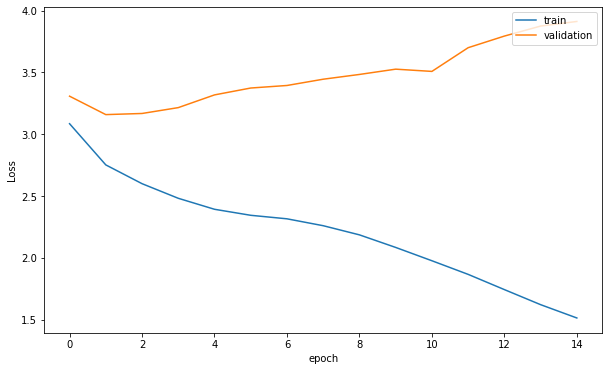

In [14]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

Plot of accuracy versus epoch

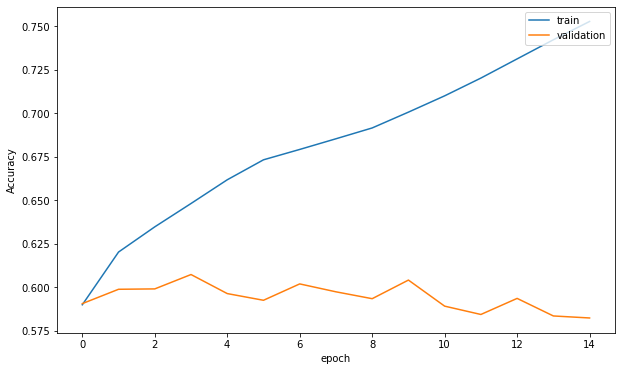

In [15]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

# Text Summarization

In [16]:
def seq2sentence(seq, index_word):
    sentence = []
    for i in seq:
        if i !=0:
            sentence.append(index_word[i])
    wordlist = sentence[1:-1]
    sentence = ' '.join(sentence[1:-1])
    return sentence, wordlist

In [17]:
size = test_y.shape[0]
size = 10
for i in range(0, size):
    print("".join(['=']*125))
    print("Sample {}".format(i))
    sentence_X, _ = seq2sentence(test_X[i], index_word_X)
    print('Original text: ', sentence_X)
    sentence, wordlist = seq2sentence(test_y[i], index_word_y)
    print('Original summary: ', sentence)
    input_seq = test_X[i].reshape(1,maxlength_txt)
    summary = edattn.summarization(input_seq, word_index_y, index_word_y)
    print('Generated summary: ', summary)
    print('\n')

Sample 0
Original text:  resignation of carlos romero who is under investigation for his unexplained wealth is an important step for president andrés manuel lópez obrador in his fight against
Original summary:  under scrutiny for wealth powerful bos of mexico oil worker union resigns
Generated summary:   mexico new look former mexican politician accused of corruption


Sample 1
Original text:  diplomat were intending to travel to a remote town in the russian arctic where a mysterious nuclear accident killed seven people in august releasing
Original summary:  russia stop you s diplomat en route to a nuclear accident site
Generated summary:   japan sends afghan signal to save a third shiite pilgrim in new york


Sample 2
Original text:  klobuchar and pete buttigieg are vying to become the pragmatic alternative to joe biden mr sander is trumpeting endorsement to compete with elizabeth
Original summary:  two person race moderate and bernie sander say not so fast
Generated summary:   bernie

# Rouge Score

In [18]:
scorer = rouge_scorer.RougeScorer(['rouge1'])

In [19]:
def summary_score(orginal_text, orginal_summary, index_word, maxlength_txt):
    sentence, wordlist = seq2sentence(orginal_summary, index_word)
    input_seq = orginal_text.reshape(1,maxlength_txt)
    summary = edattn.summarization(input_seq, word_index_y, index_word)
    precision, recall, f1 = scorer.score(sentence, summary)['rouge1']
    return precision, recall, f1

In [20]:
size = test_y.shape[0]
precision_score = []
recall_score = []
f1_score = []
for i in tqdm(range(0, size), desc="Progress", leave=False):
    precision, recall, f1 = summary_score(test_X[i], test_y[i], index_word_y, maxlength_txt)
    #print(i, "precision: {}, recall: {}, f1: {}".format(round(precision,2), round(recall,2), round(f1,2)))
    precision_score.append(precision)
    recall_score.append(recall)
    f1_score.append(f1)

In [21]:
performance = pd.DataFrame()
performance['Precision'] = precision_score
performance['Recall'] = recall_score
performance['F1'] = f1_score

In [22]:
performance.agg(['mean','std','max'])

,Precision,Recall,F1
mean,0.164819,0.134304,0.141719
std,0.203485,0.143498,0.157053
max,1.000000,1.000000,1.000000


F1 Rouge score is slightly lower than the result using the LSTM encoder in the previous example.